In [1]:
import sys
sys.path.append("..")
import torch
import torch.nn.functional as F
from omegaconf import OmegaConf
from ccreaim.model import operate, ae
from ccreaim.utils import dataset, cfg_classes, audio_tools, util

In [69]:
#data_tar = "/scratch/other/sopi/CCREAIM/datasets/test/out/maestro_chopped_65536.tar"
#trf_data_tar = "/scratch/other/sopi/CCREAIM/logs/2023-02-02/res-vqvae_train_10-58-30/4/transformer_training_data_seqlen-16384_numseq-4_latent-dim-16_num-embeddings-1024_2023-02-02-10-58-30-4.tar"
#data_tar2 = "/scratch/other/sopi/CCREAIM/datasets/maestro_chopped_65536.tar"

data_tar = "/scratch/other/sopi/CCREAIM/datasets/youtube_chopped_131072.tar"
data_tar2 = data_tar

#load_vqvae_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-02/res-vqvae_train_10-58-30/0/checkpoints/res-vqvae_seqlen-16384_bs-64_lr-1e-05_seed-0_final.pt"
#load_vqvae_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-02/res-vqvae_train_10-58-30/4/checkpoints/res-vqvae_seqlen-16384_bs-64_lr-1e-05_seed-0_final.pt"
#load_trf_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-03/transformer-decoder-only_train_13-01-03/2/checkpoints/transformer-decoder-only_seqlen-2048_bs-16_lr-0.001_seed-0_final.pt"
#load_trf_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-03/transformer-decoder-only_train_13-01-14/7/checkpoints/transformer-decoder-only_seqlen-2048_bs-16_lr-0.0001_seed-0_ep-048.pt"
#load_vqvae_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-19/res-vqvae_train_01-30-47/0/checkpoints/res-vqvae_seqlen-16384_bs-128_lr-0.0001_seed-0_ep-020.pt"
#load_trf_path = "/scratch/other/sopi/CCREAIM/logs/2023-02-20/transformer-decoder-only_train_19-34-52/3/checkpoints/transformer-decoder-only_seqlen-512_bs-16_lr-0.0001_seed-0_ep-076.pt"
load_vqvae_path = "/scratch/other/sopi/CCREAIM/logs/2023-03-05/res-vqvae_train_00-06-16/0/checkpoints/res-vqvae_seqlen-32768_bs-128_lr-0.0001_seed-0_ep-050.pt"
load_trf_path = "/scratch/other/sopi/CCREAIM/logs/2023-03-05/transformer-decoder-only_train_11-33-00/7/checkpoints/transformer-decoder-only_seqlen-2048_bs-16_lr-0.0001_seed-0_ep-340.pt"

num_seq = 4

In [70]:
# Load vq-vae model

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

vqvae_checkpoint = torch.load(load_vqvae_path, map_location="cpu")
vqvae_state_dict = vqvae_checkpoint["model_state_dict"]
hyper_cfg_schema = OmegaConf.structured(cfg_classes.HyperConfig)
vqvae_conf = OmegaConf.create(vqvae_checkpoint["hyper_config"])
vqvae_hyper_cfg = OmegaConf.merge(hyper_cfg_schema, vqvae_conf)
get_vqvae = operate.get_model_init_function(vqvae_hyper_cfg)
vqvae = get_vqvae()
vqvae.load_state_dict(vqvae_state_dict)
vqvae = vqvae.to(device)
vqvae = vqvae.eval()

In [71]:
# Load transformer model

trf_checkpoint = torch.load(load_trf_path, map_location="cpu")
trf_state_dict = trf_checkpoint["model_state_dict"]
hyper_cfg_schema = OmegaConf.structured(cfg_classes.HyperConfig)
trf_conf = OmegaConf.create(trf_checkpoint["hyper_config"])
trf_hyper_cfg = OmegaConf.merge(hyper_cfg_schema, trf_conf)
get_trf = operate.get_model_init_function(trf_hyper_cfg)
trf = get_trf()
trf.load_state_dict(trf_state_dict)
trf = trf.to(device)

In [72]:
# Prepare datasets
tmp_data_root = dataset.prepare_dataset_on_tmp(data_tar)
data = dataset.ChunkedAudioDataset(tmp_data_root, vqvae_hyper_cfg.seq_len, num_seq)

In [73]:
tmp_bigger_data_root = dataset.prepare_dataset_on_tmp(data_tar2)
data2 = dataset.ChunkedAudioDataset(tmp_data_root, vqvae_hyper_cfg.seq_len, num_seq)

In [74]:
# IF RUNNING FOR THE FIRST TIME FOR A DATASET, KEYBOARD INTERRUPT MANUALLY AND RENAME /tmp/something_preparing to /tmp/something
#tmp_trf_data_root = dataset.prepare_dataset_on_tmp(trf_data_tar) 
#trf_data = dataset.FeatureDataset(tmp_trf_data_root)

In [75]:
sample_id = 906

In [76]:
with torch.inference_mode():
    # Encode data
    sample, name, _ = data[sample_id]
    print(name)
    
    # Reshape into [num_seq, 1, seq_len], num_seq is 
    # interpreted as the batch dimension
    sample = sample.view(-1, 1, vqvae_hyper_cfg.seq_len)
    dec, enc, quantized_latents = vqvae(sample)

    # Flatten and reshape the quantized latents for the transformer, 
    # aka flatten the "batch" dimension that corresponds to the multiple encoders 
    quantized_latents = quantized_latents.transpose(-1,-2)
    vq_out_flat = quantized_latents.flatten(0,1)
    vq_out_flat = vq_out_flat.unsqueeze(0)
    print(vq_out_flat.size())
    # Tgt will be of dimension [1, num_seq*enc_out_length, latent_dim]
    tgt = torch.cat(
        (
            torch.zeros_like(vq_out_flat[:, 0:1, :], device=vq_out_flat.device),
            vq_out_flat[:, :-1, :],
        ),
        dim=1,
    )

    tgt_mask = util.get_tgt_mask(tgt.size(1))
    tgt_mask = tgt_mask.to(tgt.device)
    
    trf = trf.train()
    
    trf_out_flat = trf(
        tgt,
        tgt_mask=tgt_mask,
    )
    
    # Return the "batch" dimension that was flattened earlier
    trf_out = trf_out_flat.view(
        num_seq, enc.size(2), vqvae.vq.K  # num_embeddings
    )
    
    # VQ lookup
    emb_inds = trf_out.argmax(-1)
    trf_vq_out = vqvae.vq.lookup(emb_inds)
    trf_vq_out = trf_vq_out.transpose(-1, -2)

    
    # Decode
    dec_out = vqvae.decoder(trf_vq_out)

/tmp/youtube_chopped_131072/Queen -  I Want It All  ｜ Vkgoeswild piano cover [pDWJjpqu6ew]_16000_009.wav
torch.Size([1, 1024, 64])


In [77]:
import torchaudio

In [78]:
orig_flat = sample.flatten().unsqueeze(0)
dec_flat = dec.flatten().unsqueeze(0)
pred_flat = dec_out.flatten().unsqueeze(0)

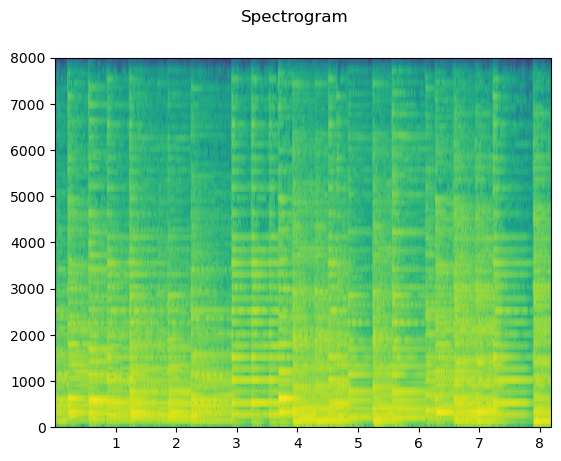

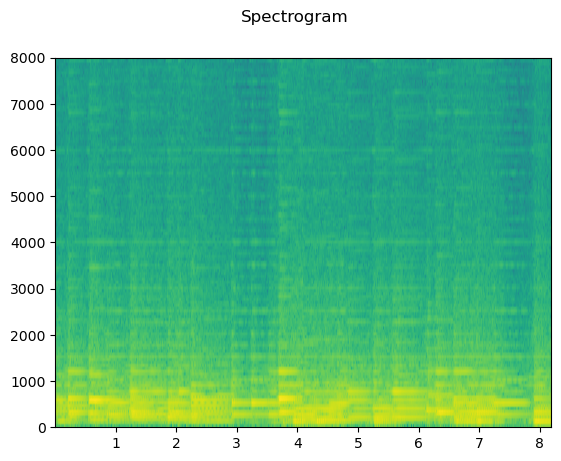

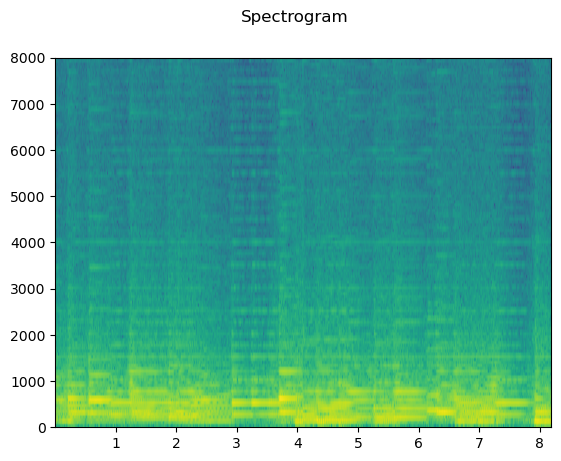

In [79]:
audio_tools.plot_specgram(orig_flat, 16000)
audio_tools.plot_specgram(dec_flat, 16000)
audio_tools.plot_specgram(pred_flat, 16000)

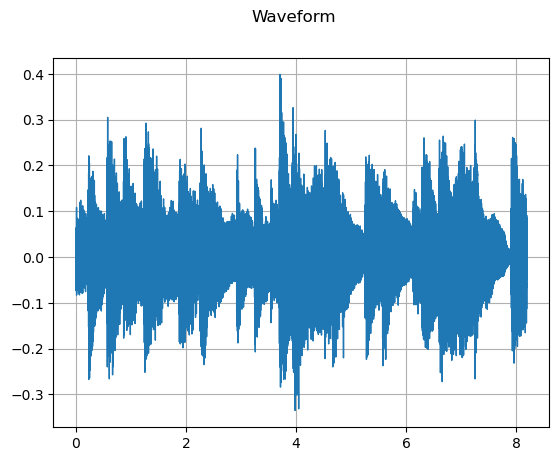

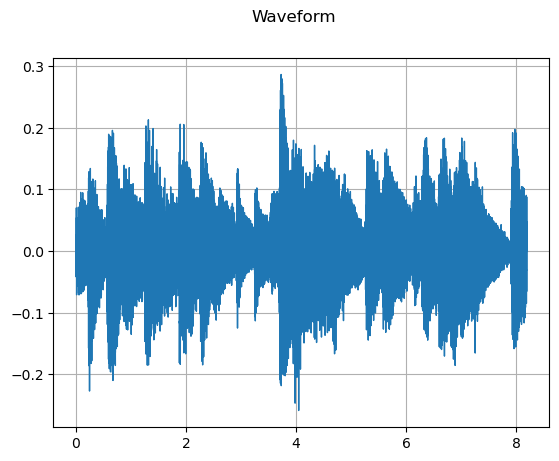

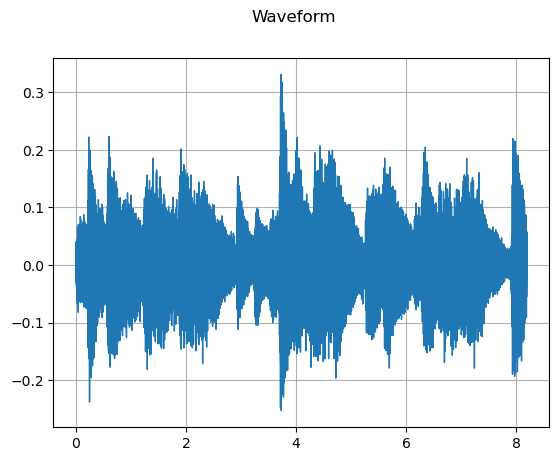

In [80]:
audio_tools.plot_waveform(orig_flat, 16000)
audio_tools.plot_waveform(dec_flat, 16000)
audio_tools.plot_waveform(pred_flat, 16000)

In [81]:
audio_tools.play_audio(orig_flat, 16000)
audio_tools.play_audio(dec_flat, 16000)
audio_tools.play_audio(pred_flat, 16000)

In [62]:
save = False
#save = True
if save:
    #torchaudio.save("./samples/epoch_comparison/example1_orig.wav", orig_flat, 16000)
    torchaudio.save("./samples/epoch_comparison/example1_vqvae_reconst.wav", dec_flat, 16000)
    torchaudio.save("./samples/epoch_comparison/example1_transformer_reconst_60epochs.wav", pred_flat, 16000)

In [63]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
    top_k = min(top_k, logits.size(-1))  # Safety check
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value
    return logits

In [82]:
top_p = 0
top_k = 3
temperature = 1.0

with torch.inference_mode():
    # Encode data
    sample, _, _ = data[sample_id]
    
    # Reshape into [num_seq, 1, seq_len], num_seq is 
    # interpreted as the batch dimension
    sample = sample.view(-1, 1, vqvae_hyper_cfg.seq_len)
    print(sample.size())
    dec, enc, quantized_latents = vqvae(sample)
    print(quantized_latents.size())
    out_length = quantized_latents.size(-1)
    
    
    # Pick the first half of the latents
    quantized_latents_half = quantized_latents[:num_seq//2,:,:]
    
    #print(quantized_latents_half.size())
    #print(quantized_latents_half)
    
    # Flatten and reshape the quantized latents for the transformer, 
    # aka flatten the "batch" dimension that corresponds to the multiple encoders 
    quantized_latents_half = quantized_latents_half.transpose(-1,-2)
    vq_out_flat = quantized_latents_half.flatten(0,1)
    vq_out_flat = vq_out_flat.unsqueeze(0)
    
    # Tgt will be of dimension [1, (num_seq//2)*enc_out_length, latent_dim]
    tgt = torch.cat(
        (
            torch.zeros_like(vq_out_flat[:, 0:1, :], device=vq_out_flat.device),
            vq_out_flat[:, :-1, :],
        ),
        dim=1,
    )
    #print(tgt.size())
    #print(tgt)
    # No mask needed for generation
    #tgt_mask = util.get_tgt_mask(tgt.size(1))
    #tgt_mask = tgt_mask.to(tgt.device)
    
    # Fix into cached version later, now just work with original trf implementation for simplicity
    trf = trf.train()
    
    n = num_seq*enc.size(2)//2
    for i in range(n+1):
        if i % 100 == 0:
            print(f"{i/n*100} %")
        trf_out_flat = trf(tgt)

        filtered_trf_out_flat = top_k_top_p_filtering(trf_out_flat[:,-1,:].squeeze()/temperature, top_k=top_k, top_p=top_p)
        probabilities = F.softmax(filtered_trf_out_flat)
        emb_ind = torch.multinomial(probabilities,1)
        #emb_ind = trf_out_flat[:,-1,:].argmax(-1)
        
        #emb_ind = torch.multinomial(F.softmax(trf_out_flat[:,-1,:], -1), 1)
        #emb_ind = emb_ind.squeeze(0)
        #emb_ind = torch.clamp(torch.round(torch.randn(1)*512)+512,0,1023)
        #emb_ind = emb_ind.int()
        #print(emb_ind)
        #print(vqvae.vq.lookup(emb_ind).unsqueeze(0).size())
        #print(tgt.size())
        next_quantized_vec = vqvae.vq.lookup(emb_ind).unsqueeze(0)
        tgt = torch.cat((tgt, vqvae.vq.lookup(emb_ind).unsqueeze(0)), dim=1)
        #print(tgt.size())
    
    # Return the "batch" dimension that was flattened earlier
    #trf_out = trf_out_flat.view(
    #    num_seq, enc_out_length, vqvae.vq.K  # num_embeddings
    #)
    #print(tgt.size())
    
    # VQ lookup
    #emb_inds = trf_out.argmax(-1)
    #trf_vq_out = vqvae.vq.lookup(emb_inds)
    #trf_vq_out = trf_vq_out.transpose(-1, -2)
    tgt = tgt[:, 1:, :]
    #print(tgt.size())
    #print(tgt)
    tgt = tgt.view(num_seq, out_length, vqvae_hyper_cfg.latent_dim)
    tgt = tgt.transpose(-1,-2)
    #print(tgt.size())
    #Sprint(tgt)
    # Decode
    dec_out = vqvae.decoder(tgt)

torch.Size([4, 1, 32768])
torch.Size([4, 64, 256])
0.0 %


/tmp/ipykernel_14463/3920488503.py:54: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(filtered_trf_out_flat)


19.53125 %
39.0625 %
58.59375 %
78.125 %
97.65625 %


In [83]:
orig_flat = sample.flatten().unsqueeze(0)
dec_flat = dec.flatten().unsqueeze(0)
gen_flat = dec_out.flatten().unsqueeze(0)

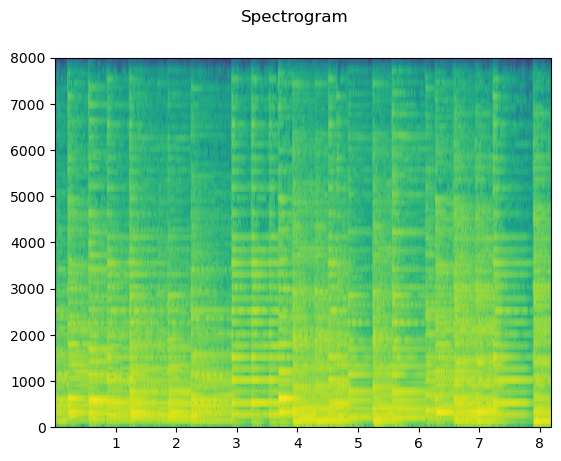

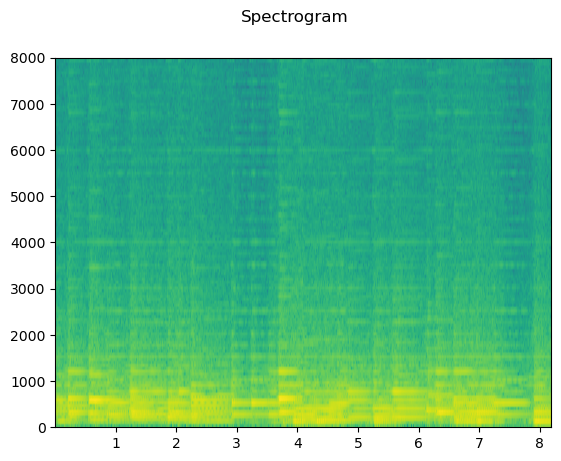

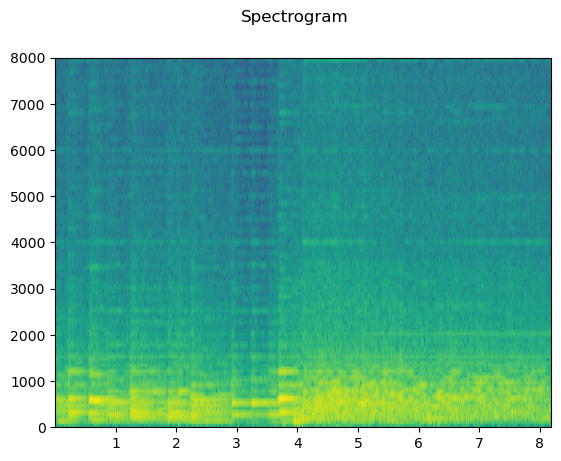

In [84]:
audio_tools.plot_specgram(orig_flat, 16000)
audio_tools.plot_specgram(dec_flat, 16000)
audio_tools.plot_specgram(gen_flat, 16000)

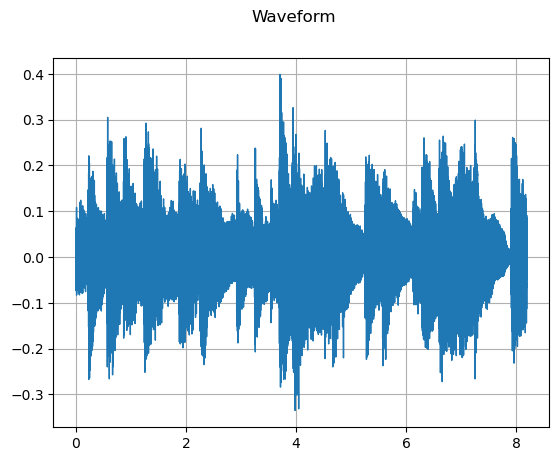

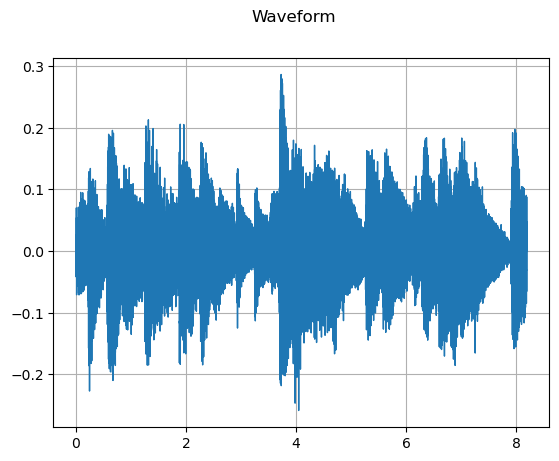

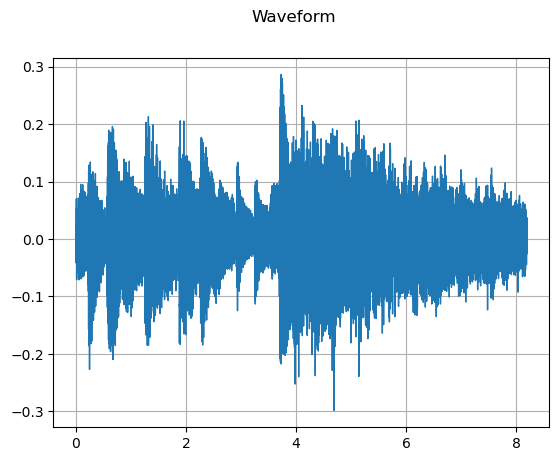

In [85]:
audio_tools.plot_waveform(orig_flat, 16000)
audio_tools.plot_waveform(dec_flat, 16000)
audio_tools.plot_waveform(gen_flat, 16000)

In [86]:
audio_tools.play_audio(orig_flat, 16000)
audio_tools.play_audio(dec_flat, 16000)
audio_tools.play_audio(gen_flat, 16000)

In [22]:
save = False
#save = True
if save:
    torchaudio.save("./samples/nucleus_top_k/sample8_orig.wav", orig_flat, 16000)
    torchaudio.save("./samples/nucleus_top_k/sample8_gen.wav", gen_flat, 16000)

In [23]:
# ATTEMPTING CACHE USAGE, 
# but doesn't work with current implementation for multiple layer transformer
# The first iteration should be same as usual, where each layer calculates each output, then
# those should be cached.

with torch.inference_mode():
    # Encode data
    sample, _, _ = data[32]
    
    # Reshape into [num_seq, 1, seq_len], num_seq is 
    # interpreted as the batch dimension
    sample = sample.view(-1, 1, vqvae_hyper_cfg.seq_len)
    print(sample.size())
    dec, enc, quantized_latents = vqvae(sample)
    print(quantized_latents.size())
    out_length = quantized_latents.size(-1)
    
    
    # Pick the first half of the latents
    quantized_latents_half = quantized_latents[:num_seq//2,:,:]
    
    print(quantized_latents_half.size())
    print(quantized_latents_half)
    
    # Flatten and reshape the quantized latents for the transformer, 
    # aka flatten the "batch" dimension that corresponds to the multiple encoders 
    quantized_latents_half = quantized_latents_half.transpose(-1,-2)
    vq_out_flat = quantized_latents_half.flatten(0,1)
    vq_out_flat = vq_out_flat.unsqueeze(0)
    
    # Tgt will be of dimension [1, (num_seq//2)*enc_out_length, latent_dim]
    tgt = torch.cat(
        (
            torch.zeros_like(vq_out_flat[:, 0:1, :], device=vq_out_flat.device),
            vq_out_flat[:, :-1, :],
        ),
        dim=1,
    )
    print(tgt.size())
    print(tgt)
    # No mask needed for generation
    #tgt_mask = util.get_tgt_mask(tgt.size(1))
    #tgt_mask = tgt_mask.to(tgt.device)
    
    trf = trf.eval()
    
    n = 1024
    cache = None
    for i in range(n+1):
        if i % 100 == 0:
            print(f"{i/n*100} %")
        trf_out_flat = trf.positional_encoder(tgt)
        trf_out_flat, cache = trf.transformer_decoder(trf_out_flat, cache=cache)
        #print(cache.size())
        trf_out_flat = trf.trf_out_to_tokens(trf_out_flat)
        #print(trf_out_flat.size())
        emb_ind = trf_out_flat[:,-1,:].argmax(-1)
        #print(emb_ind)
        #print(vqvae.vq.lookup(emb_ind).unsqueeze(0).size())
        #print(tgt.size())
        next_quantized_vec = vqvae.vq.lookup(emb_ind).unsqueeze(0)
        #print(next_quantized_vec)
        tgt = torch.cat((tgt, vqvae.vq.lookup(emb_ind).unsqueeze(0)), dim=1)
        #print(tgt.size())
    
    # Return the "batch" dimension that was flattened earlier
    #trf_out = trf_out_flat.view(
    #    num_seq, enc_out_length, vqvae.vq.K  # num_embeddings
    #)
    print(tgt.size())
    
    # VQ lookup
    #emb_inds = trf_out.argmax(-1)
    #trf_vq_out = vqvae.vq.lookup(emb_inds)
    #trf_vq_out = trf_vq_out.transpose(-1, -2)
    tgt = tgt[:, 1:, :]
    print(tgt.size())
    print(tgt)
    tgt = tgt.view(num_seq, out_length, vqvae_hyper_cfg.latent_dim)
    tgt = tgt.transpose(-1,-2)
    print(tgt.size())
    print(tgt)
    # Decode
    dec_out = vqvae.decoder(tgt)

torch.Size([4, 1, 16384])
torch.Size([4, 64, 128])
torch.Size([2, 64, 128])
tensor([[[-18.0328, -18.1503, -18.1737,  ..., -18.2028, -18.1890, -18.0959],
         [ 12.3931,  12.1802,  12.1912,  ...,  12.2164,  12.3157,  12.3936],
         [ -9.1638,  -8.9984,  -8.9836,  ...,  -9.1041,  -9.0470,  -9.5761],
         ...,
         [ -1.0186,  -0.6851,  -0.8553,  ...,  -0.5978,  -0.7209,  -0.9159],
         [  7.5637,   7.4580,   7.5754,  ...,   7.5765,   7.5766,   7.1182],
         [ -3.7632,  -3.8084,  -3.8509,  ...,  -3.8222,  -3.7860,  -4.0917]],

        [[-18.0642, -18.1489, -18.1048,  ..., -18.0909, -18.1463, -18.1799],
         [ 12.3583,  12.2737,  12.2319,  ...,  12.4733,  12.2037,  11.9865],
         [ -9.1751,  -8.9677,  -9.2321,  ...,  -8.9934,  -9.0097,  -8.4586],
         ...,
         [ -0.9047,  -0.6654,  -0.9648,  ...,  -1.0626,  -1.0575,  -0.7138],
         [  7.6061,   7.7996,   7.7178,  ...,   7.8919,   7.7930,   8.1074],
         [ -3.7286,  -3.6090,  -3.8303,  ...,  

RuntimeError: shape '[4, 128, 64]' is invalid for input of size 81920

In [24]:
orig_flat = sample.flatten().unsqueeze(0)
dec_flat = dec.flatten().unsqueeze(0)
gen_flat = dec_out.flatten().unsqueeze(0)

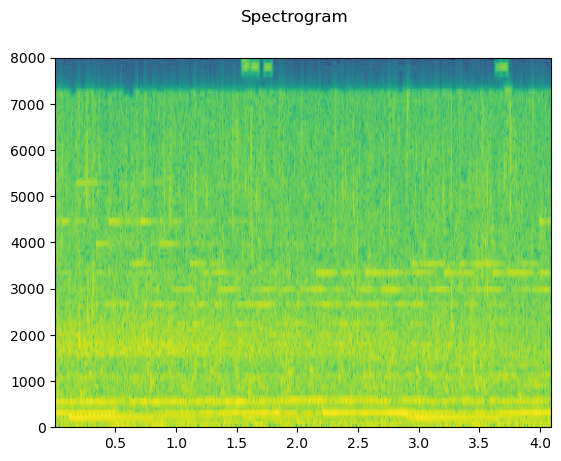

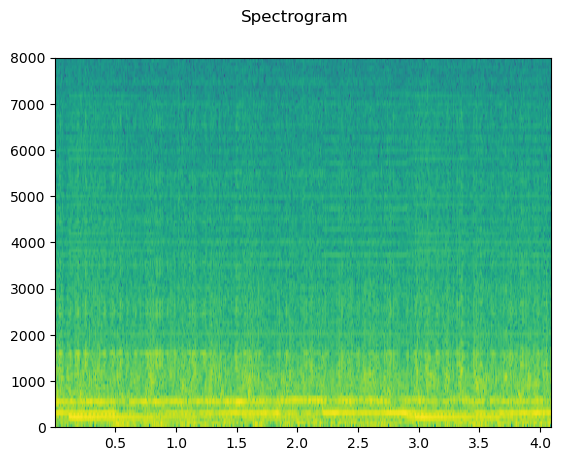

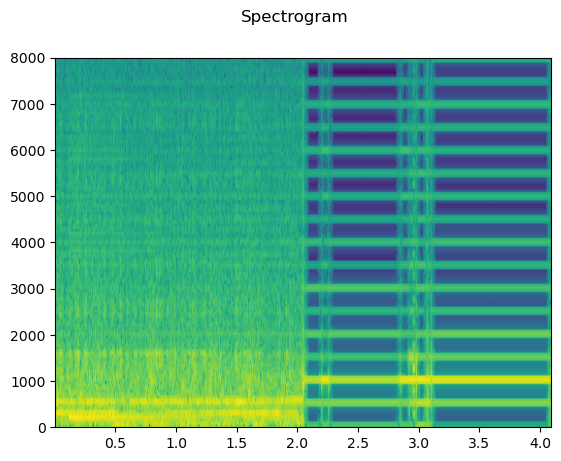

In [25]:
audio_tools.plot_specgram(orig_flat, 16000)
audio_tools.plot_specgram(dec_flat, 16000)
audio_tools.plot_specgram(gen_flat, 16000)

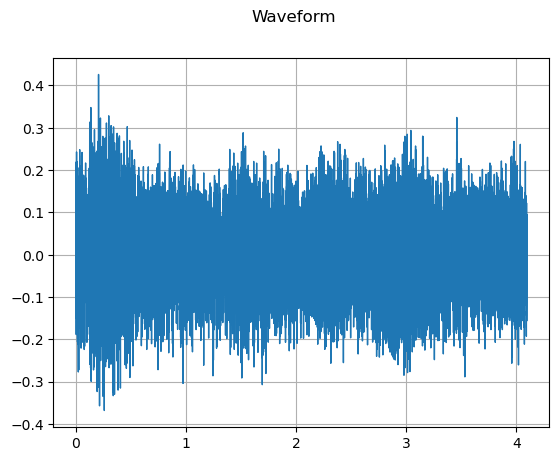

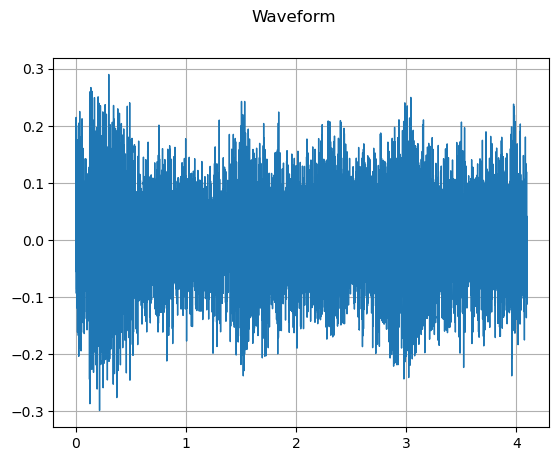

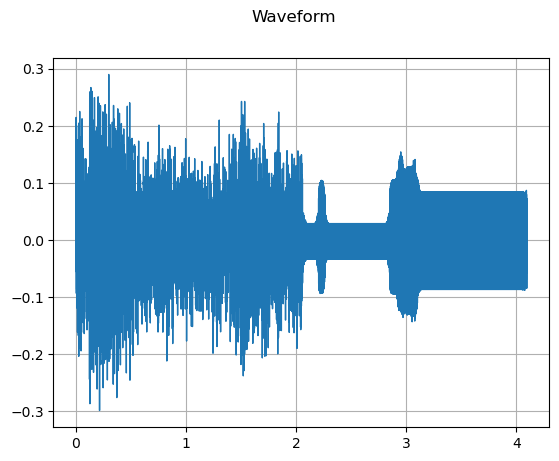

In [26]:
audio_tools.plot_waveform(orig_flat, 16000)
audio_tools.plot_waveform(dec_flat, 16000)
audio_tools.plot_waveform(gen_flat, 16000)

In [27]:
audio_tools.play_audio(orig_flat, 16000)
audio_tools.play_audio(dec_flat, 16000)
audio_tools.play_audio(gen_flat, 16000)

In [196]:
chunked_dataloader = torch.utils.data.DataLoader(
            data,
            batch_size=vqvae_hyper_cfg.batch_size,
            shuffle=False,
            num_workers=1,
        )

In [194]:
def prepare_data_for_transformer1(
    data, encoder, vq, seq_len, num_seq, enc_out_length, latent_dim
):
    data, _, _ = data
    data_orig = data
    data = data.view(-1, 1, seq_len)
    enc_out_batch = encoder(data)
    enc_out_batch = enc_out_batch.transpose(-1, -2)
    enc_out = enc_out_batch.view(-1, num_seq, enc_out_length, latent_dim)
    enc_out_flat = enc_out.flatten(1, 2)  # merge into sequence of vectors

    # VQ
    quantized_latents, vq_inds = vq(enc_out_flat.transpose(-1, -2))
    vq_inds = vq_inds.view(-1, num_seq, enc_out_length)

    quantized_latents = quantized_latents.transpose(-1, -2)
    quantized_latents_res = enc_out_flat + (quantized_latents - enc_out_flat).detach()
    vq_out = quantized_latents_res.view(-1, num_seq, enc_out_length, latent_dim)
    vq_out_flat = vq_out.flatten(1, 2)  # merge into sequence of vectors

    return vq_out_flat, vq_inds

def prepare_data_for_transformer2(
    data, encoder, vq, seq_len, num_seq, enc_out_length, latent_dim
):
    seq, _, _ = data
    
    batch_size = seq.size(0)
    #print(seq.size())
    vq_out_flat = torch.zeros(batch_size, enc_out_length*num_seq, latent_dim)
    inds_out_flat = torch.zeros(batch_size, enc_out_length*num_seq)
    for i in range(batch_size):
        sample = seq[i,:,:]
        sample = sample.view(-1, 1, seq_len)
        enc = encoder(sample)
        quantized_latents, vq_inds = vq(enc)
        quantized_latents = quantized_latents.transpose(-1,-2)
        flat_q_latents = quantized_latents.flatten(0,1)
        #print(vq_inds.size())
        flat_inds = vq_inds.flatten(0,1)
        #print(flat_inds.size())
        vq_out_flat[i,:,:] = flat_q_latents
        inds_out_flat[i,:] = flat_inds
        
    # Encode data:    
    # Reshape into [num_seq, 1, seq_len], num_seq is 
    # interpreted as the batch dimension
    #sample = sample.view(-1, 1, vqvae_hyper_cfg.seq_len)
    #dec, enc, quantized_latents = vqvae(sample)

    # Flatten and reshape the quantized latents for the transformer, 
    # aka flatten the "batch" dimension that corresponds to the multiple encoders,
    # need to keep the actual batch dimension though
    #quantized_latents = quantized_latents.transpose(-1,-2)
    #vq_out_flat = quantized_latents.flatten(0,1)
    #vq_out_flat = vq_out_flat.unsqueeze(0)

    return vq_out_flat, inds_out_flat

In [198]:
enc_out_length=512
vq_out_flat1, vq_ind1 = prepare_data_for_transformer1(next(iter(chunked_dataloader)), vqvae.encoder, vqvae.vq, vqvae_hyper_cfg.seq_len, num_seq, enc_out_length, vqvae_hyper_cfg.latent_dim)
print(vq_out_flat1.size())
print(vq_ind1.size())
print(vq_ind1.flatten(1,2).size())
print(vq_ind1)
print(vq_ind1.flatten(1,2))
print(vq_ind1.view(-1))

vq_out_flat2, vq_ind2 = prepare_data_for_transformer2(next(iter(chunked_dataloader)), vqvae.encoder, vqvae.vq, vqvae_hyper_cfg.seq_len, num_seq, enc_out_length, vqvae_hyper_cfg.latent_dim)
print(vq_out_flat2.size())
print(vq_ind2.size())
print(vq_out_flat1[10,:,:])
print(vq_out_flat2[10,:,:])
print(vq_ind1.flatten(1,2)[10,:])
print(vq_ind2[10,:])


torch.Size([64, 2048, 16])
torch.Size([64, 4, 512])
torch.Size([64, 2048])
tensor([[[ 622,   59,  492,  ...,  728,   60,  468],
         [ 980,  319,   45,  ...,  257,  836,  260],
         [  10,  266,  296,  ...,   43,   84,   76],
         [ 177,   29,  266,  ...,  102,  305,  102]],

        [[ 553,  658,  722,  ...,  183,  242,  372],
         [  41,  580,  612,  ...,  519,   52, 1003],
         [ 268,  814,  344,  ...,  974,  684,  637],
         [ 327,  330,  380,  ...,  460,  125,  180]],

        [[   5,  798,  141,  ...,   85,  159,  185],
         [ 842,  952,  352,  ...,  590,  498,  343],
         [ 961,  790,  391,  ...,  591,  775,  151],
         [ 356,  262,  235,  ..., 1013,  174,  185]],

        ...,

        [[ 961,  790, 1013,  ...,  271,  245,    2],
         [  31,  256,  261,  ...,   64,  920,  654],
         [ 292,   78,  217,  ...,  411,  747,  979],
         [ 230,  589,   47,  ...,  952,  799,  775]],

        [[ 660,  492,  546,  ...,   37,  174,  687],
  

In [206]:
print(vq_ind1.view(-1)[2048*64-1])

tensor(366)


In [154]:
import torchaudio

In [156]:
waveform, sample_rate = torchaudio.load("/tmp/youtube_chopped_131072/With a song and love from Zanzibar [Wcta7DEJX34]_000.wav", format="wav")
print(sample_rate)

48000
